# Kepler Planet Lightcurve Analysis Dashboard
### Run all of the cells in order unless otherwise indicated. If dropdown menus or input boxes are used, be sure to rerun all of the following cells as some later cells may be dependent on the changes in earlier ones.
## Run the following cell to import the required modules

In [1]:
try:
    %matplotlib widget
    import sys
    import os
    import numpy as np
    from astroquery.mast import Observations
    from astropy.io import fits
    import matplotlib
    import matplotlib.pyplot as plt
    import astropy.units as u
    from scipy.signal import savgol_filter
    from astropy.timeseries import BoxLeastSquares
    import ipywidgets as widgets
    normalstdout=sys.stdout
except:
    print("Please be sure the following modules are installed:\n\n\tnumpy, matplotlib, scipy, ipympl, ipywidgets, astroquery, astropy\n")
    try:
        t1=input("Would you like to attempt auto-install? (y=yes other=no)\n")
        if t1=='y':
            def install(module):import subprocess;import sys;exec(f'subprocess.check_call([sys.executable, "-m", "pip", "install", "{module}"])')
            for i in ["numpy", "matplotlib", "scipy", "ipympl", "ipywidgets", "astroquery", "astropy"]:
                install(i)
    except:
        print("Auto-install failed. Please install the following modules manually:\n\n\tnumpy, matplotlib, scipy, ipympl, ipywidgets, astroquery, astropy\n\nThen restart this notebook.\n")
    print()
    print("After installing all modules, run the command line command 'jupyter nbextension enable --py widgetsnbextension' and restart this Jupyter notebook.")

## Run the following cell to input a Kepler ID for analysis

In [2]:
#Gathering options for given keplername
#mainpath=input(f"Choose an existing filepath for data to be saved under\n(or press enter to save alongside this .py file)\n")
#if not mainpath:mainpath=os.getcwd()
mainpath=os.getcwd()
if mainpath[-1]=='/':mainpath=mainpath[:-1]
mainpath=mainpath.strip()
if not os.path.exists(mainpath):os.mkdir(mainpath)
keplername=input(f"\nChoose a Kepler ID (Kepler-10 for example)\n")

print(f"Gathering obs_id for {keplername} (Please wait...)")
obs=Observations.query_criteria(obs_collection=["Kepler"],objectname=keplername,radius=0)
obs_list=list(obs['obs_id'])
flux_filt=err_filt=time_filt=filt=product=products=products_list=None
print("Done")


Choose a Kepler ID (Kepler-10 for example)
 kepler 10


Gathering obs_id for kepler 10 (Please wait...)
Done


## Run the following cell to choose an obs_id
### Short cadence (sc) data should yield better results, but will be slower to process

In [5]:
def obs_menu(obs_id=obs_list[0]):
    global products
    global products_list
    print("Loading...")
    products=Observations.get_product_list(obs[obs_list.index(obs_id)])
    products_list=list(products['description'])
    products_list=[i for i in products_list if "lightcurve" in i.lower() and "cadence" in i.lower() and "tar" not in i.lower()]
    print("Done")
print("\nChoose an obs_id\n")
widgets.interact(obs_menu,obs_id=obs_list);


Choose an obs_id



interactive(children=(Dropdown(description='obs_id', options=('kplr011904151_lc_Q111111110111011101', 'kplr011…

## Run the following cell to choose a dataset
### Files of the same description will be automatically combined

In [6]:
def product_menu(description=products_list[0]):
    global product
    print("Loading...")
    product=Observations.filter_products(products,description=description)
    print("Done")
print("\nChoose a product\n")
widgets.interact(product_menu,description=products_list);


Choose a product



interactive(children=(Dropdown(description='description', options=('Lightcurve Long Cadence (CLC) - Q0', 'Ligh…

## Run the following cell to download the data

In [342]:
#Collecting and combining data for chosen observation
time,flux,err=np.array([],np.float32),np.array([],np.float32),np.array([],np.float32)
#savedata=input("\nWould you like to save the data for future use? (y=yes, other=no)\n")
#if savedata.lower()=='y':savedata=True
#else:savedata=False
savedata=True
for i in range(len(product)):
    filepath=f"/mastDownload/{product['obs_collection'][i]}/{product['obs_id'][i]}/{product['productFilename'][i]}"
    if savedata and (not os.path.exists(f"{mainpath}{filepath}")):
        f=open(os.devnull,'w')
        print("Downloading Data...")
        print("(This may take a while)")
        sys.stdout=f
        Observations.download_products(product,download_dir=mainpath)
        f.close();sys.stdout=normalstdout
    temp=fits.open(f"{mainpath}{filepath}")[1].data
    time,flux,err=np.append(time,temp["TIME"]),np.append(flux,temp["SAP_FLUX"]),np.append(err,temp["SAP_FLUX_ERR"])
if len(time)<50:
    print("Warning: data contains <50 entries")

#Allow for saving plotted figures
if not os.path.exists(f"{mainpath}/plots"):os.mkdir(f"{mainpath}/plots")
#save=input("\nChoose a name.ext for saved plots (or press enter to use temp names)\n")
#if save=="":save="temp.pdf"
save="temp.pdf"
print("Done")

Done


## Run the following cell AFTER doing the rest of the cells to repeat the process to find multiple planets, then run the rest of the cells in order again
### This cell subtracts out the points within the transits found using the following cells
#### This cell will also use the modifications from the (optional) cell below

In [353]:
t1=input("Are you sure you want to run the multi-planet model now? (y=yes other=no)")
if t1=='y':
    print("Running...")
    try:
        in_transit=model.transit_mask(time,period,2*duration,time0)
        time=time[~in_transit]
        flux=flux[~in_transit]
        err=err[~in_transit]
        print("Done")
    except:
        print("Execution failed. Did you run all of the later cells?")

Are you sure you want to run the multi-planet model now? (y=yes other=no) y


Running...
Done


## Run the following cell to plot the raw data
### The plots are interactive, allowing zooming in and saving images

Plotting Raw Data...


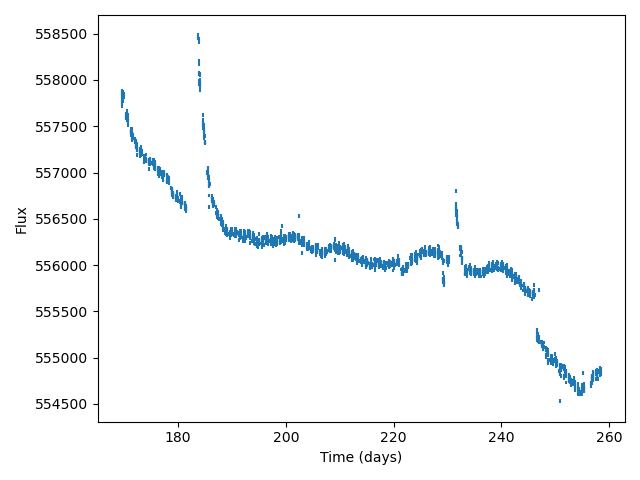

In [354]:
#Plotting raw data
print("Plotting Raw Data...")
plt.close(1)
plt.figure(1)
plt.errorbar(time,flux,err,fmt=',')
plt.xlabel("Time (days)")
plt.ylabel("Flux")
plt.tight_layout()
plt.savefig(f"{mainpath}/plots/raw_{save}")
plt.show()

## Run the following cell to filter the data
### A Savitzky–Golay filter is used, and its parameters can be adjusted

In [355]:
#Clean the data
#Remove NaN
t1=(~np.isnan(time))&(~np.isnan(flux))
time_clean=time[t1]
flux_clean=flux[t1]
err_clean=err[t1]
#Flatten data
window_text=widgets.IntText(101)
degree_text=widgets.IntText(2)
print("Press enter after changing the values")
def filter_menu(window=101,degree=2):
    global flux_filt,err_filt,time_filt
    print("Loading...")
    filt=savgol_filter(flux_clean,window,degree)
    flux_filt=flux_clean/filt
    err_filt=err_clean/filt
    #Remove outliers
    t1=np.abs(1-flux_filt)<2*np.std(flux_filt)
    time_filt=time_clean[t1]
    flux_filt=flux_filt[t1]
    err_filt=err_filt[t1]
    print("Done")
    print(f"Window: {window}\nDegree: {degree}")
widgets.interact(filter_menu,window=window_text,degree=degree_text);

Press enter after changing the values


interactive(children=(IntText(value=101, description='window'), IntText(value=2, description='degree'), Output…

## Run the following cell to plot the cleaned data

Plotting Cleaned Data...


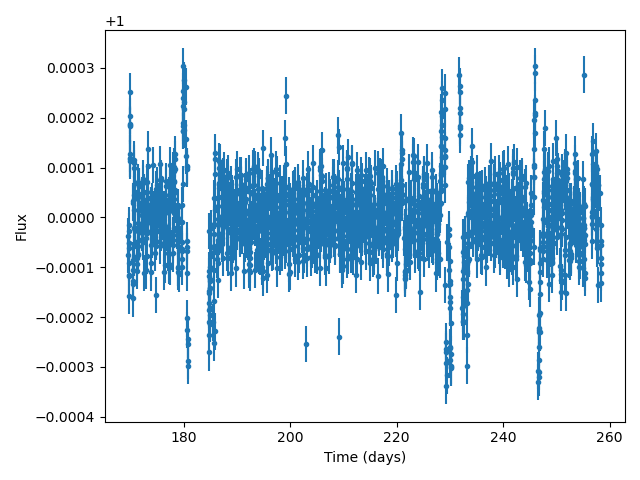

In [356]:
print("Plotting Cleaned Data...")
#filt=savgol_filter(flux_clean,51,2)
plt.close(2)
plt.figure(2)
plt.errorbar(time_filt,flux_filt,err_filt,fmt='.')
plt.xlabel("Time (days)")
plt.ylabel("Flux")
plt.tight_layout()
plt.savefig(f"{mainpath}/plots/clean_{save}")
plt.show()

## Run the following cell to plot the periodogram

Plotting Periodogram...


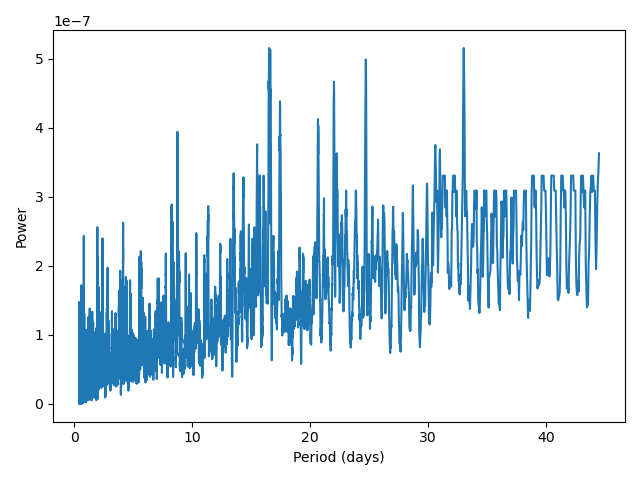

In [357]:
#Create box least squares model
print("Plotting Periodogram...")
model=BoxLeastSquares(time_filt,flux_filt)
periodogram=model.autopower(0.2)
plt.close(3)
plt.figure(3)
plt.plot(periodogram.period,periodogram.power)
plt.xlabel("Period (days)")
plt.ylabel("Power")
plt.tight_layout()
plt.savefig(f"{mainpath}/plots/box_{save}")
plt.show()
periods=np.array(periodogram.period)
powers=np.array(periodogram.power)

### (Optional) Run this cell to select a custom range of periods from the graph above to analyze
#### Input the same period twice to analyze that specific period. This can be repeated, so whatever range was chosen last will be used

In [364]:
t1=input("Are you sure you want to select a custom range? (y=yes other=no)")
if t1=='y':
    try:
        periods=np.array(periodogram.period)
        powers=np.array(periodogram.power)
        low=np.argmin(np.abs(periods-float(input("Choose a minimum period:\n"))))
        hig=np.argmin(np.abs(periods-float(input("Choose a maximum period:\n"))))
        powers[:low]=0
        powers[hig+1:]=0
    except:
        print("Execution failed.")

Are you sure you want to select a custom range? (y=yes other=no) n


## Run the following cell to plot the folded data


Transit period in days appears to be: 33.0156518795714

This may indicate that there is no planet, or that it has a period larger than can be analyzed from this data.

Plotting Folded Data...


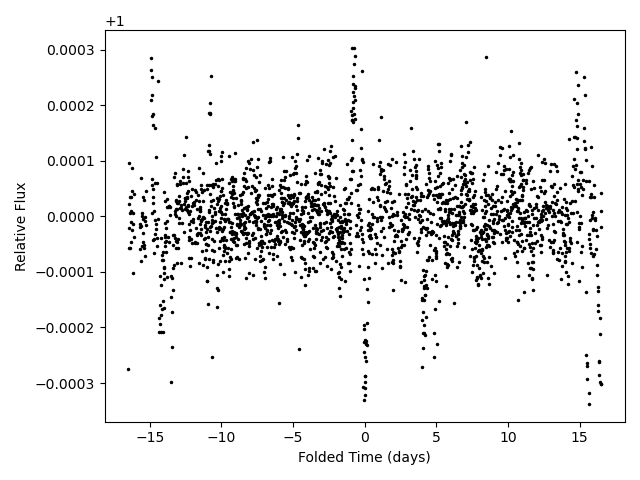

In [359]:
#Analyze model
max_power=np.argmax(powers)
period=periodogram.period[max_power]
duration=periodogram.duration[max_power]
time0=periodogram.transit_time[max_power]
print(f"\nTransit period in days appears to be: {period}\n")
if (time[-1]-time[0])/period<10:
    print("WARNING: the extracted period is large compared to the timespan of the given dataset.\nThis may indicate that there is no planet, or that it has a period larger than can be analyzed from this data.\n")
stats=model.compute_stats(period,duration,time0)
print("Plotting Folded Data...")
#Folded data
timefold=(time_filt-stats['transit_times'][0]-period/2)%period-period/2
plt.close(4)
plt.figure(4)
plt.plot(timefold,flux_filt,'.k',ms=3)
plt.xlabel("Folded Time (days)")
plt.ylabel("Relative Flux")
plt.tight_layout()
plt.savefig(f"{mainpath}/plots/fold_{save}")
plt.show()

## Run the following cell to see the predicted transit model overlayed on the cleaned data
### This model is still a work in progress, but it should at least show whether the period and duration are accurate

Plotting Fitted Raw Data...


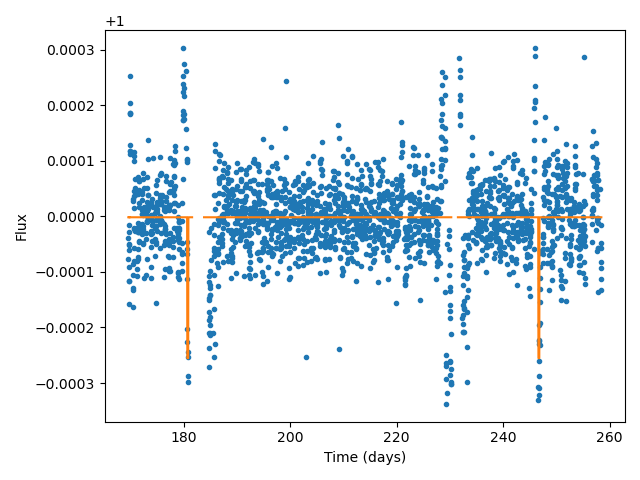

In [360]:
#Plotting raw data
print("Plotting Fitted Raw Data...")
model_box=model.model(time,period,duration,time0)
#plt.plot(time,model_box)

plt.close(5)
plt.figure(5)
plt.plot(time_filt,flux_filt,'.')
plt.plot(time,model_box)
plt.xlabel("Time (days)")
plt.ylabel("Flux")
plt.tight_layout()
plt.savefig(f"{mainpath}/plots/clean_{save}")
plt.show()

## Run the following cell to see the predicted transit times overlayed on the raw data

Plotting Raw Data...


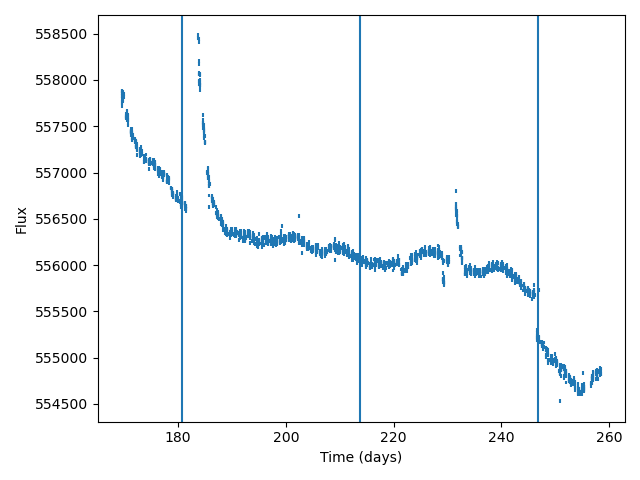

In [361]:
#Plotting raw data
print("Plotting Raw Data...")
plt.close(1)
plt.figure(1)
plt.errorbar(time,flux,err,fmt=',')
for i in stats['transit_times']:
    plt.axvline(i)
plt.xlabel("Time (days)")
plt.ylabel("Flux")
plt.tight_layout()
plt.show()

## Below are potential features to be added in the future

### Calculating planetary radii
#### In order to calculate the planetary radius, the following formula can be used:$$R_p=R_\star*\sqrt{\delta}$$The radius of the planet is equal to the radius of the star times the square root of the transit depth.
#### The transit depth can be manually calculated by finding the flux at a point before a transit $f_1$ and the flux during a transit $f_2$ and the depth can be found as $\delta=1-\frac{f_2}{f_1}$. Then, the radius of the star can be queried from a database, or many Kepler stars can be found on Wikipedia.
#### The transit depth appears to be calculated using the code below, but it seems to be highly inaccurate, as can be seen in the model above. 

In [363]:
t1=stats['depth']
print(f"Predicted (Rp/Rs)^2: {t1[0]}")
print(f"Error: {t1[1]}")
if 2*t1[1]>t1[0]:
    print("WARNING: error is more than half the size of the predicted value")

Predicted (Rp/Rs)^2: 0.00025379814150672253
Error: 0.25095238440118717
